In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import datetime

In [35]:
df = pd.read_csv('Toggl_time_entries_2022-01-01_to_2022-12-31 (1).csv')

# Drop redundant fields
df = df.drop(['User', 'Email', 'Client', 'Billable', 'Amount ()'], axis=1)

# Convert duration string to seconds (int)
df['Duration']=pd.to_timedelta(df['Duration']).astype('timedelta64[s]').astype(int) / 60

# Combine date
df['Start'] = pd.to_datetime(df['Start date'] + ' ' + df['Start time'], yearfirst=True)
df['End'] = pd.to_datetime(df['End date'] + ' ' + df['End time'], yearfirst=True)

# Drop nans in project. Uncomment these lines to explore nans
# print('NANs in PROJECT: ')
# display(df[df.Project.isna()])
df = df[df.Project.notna()]


# TODO: Remove this after testing and when you have more data. Removes out old projects
df = df[(df.Project != 'Applied Data Science') & (df.Project != 'Statistics for Data Science') & (df.Project != 'Machine Learning 1') & (df.Project != 'MSc Project') & (df.Project != 'ML2') & (df.Project != 'BML') & (df.Project != 'Reinforcement Learning')]

In [51]:
display(pd.DataFrame(df.Project.unique(), columns=['Unique Projects']).style.hide_index())

C:\Users\johng\AppData\Local\Temp\ipykernel_13980\3503174286.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  display(pd.DataFrame(df.Project.unique(), columns=['Unique Projects']).style.hide_index())


Unique Projects
To-Do
Notes
Data Science


### 🔴 1. Monthly Breakdown

In [55]:
df_month.head()

,Start,Project,Task,Duration,Tags
0,January,Notes,0.0,2.860833,0.0
1,January,To-Do,0.0,13.160278,0.0
2,February,Notes,0.0,1.210556,0.0
3,February,To-Do,0.0,24.576944,0.0
4,March,Notes,0.0,2.017222,0.0


In [70]:
df_month = df.copy()
df_month = df_month.groupby([df_month['Start'].dt.month, 'Project']).sum()
df_month = df_month.reset_index()
df_month['Duration'] /= 60
df_month = df_month.drop(['Task', 'Tags'], axis=1)

df_month['Start'] = df_month['Start'].map(
    { 1 : "January",
       2 : "February",
       3 : "March",
       4 : "April",
       5 : "May",
       6 : "June",
       7 : "July",
       8 : "August",
       9 : "September",
       10 : "October",
       11 : "November",
       12 : "December"})

df_month.head()

,Start,Project,Duration
0,January,Notes,2.860833
1,January,To-Do,13.160278
2,February,Notes,1.210556
3,February,To-Do,24.576944
4,March,Notes,2.017222


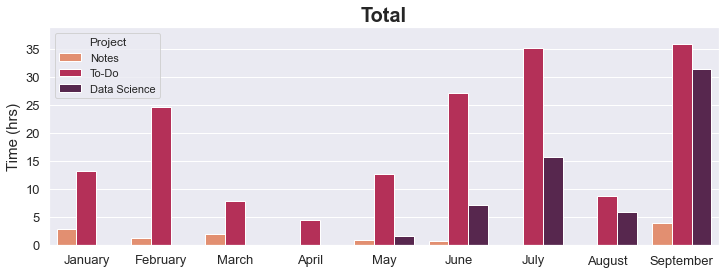

In [81]:
figsize=(12,4)
legendsize=10
title_size=20
bar_label_size=17
x_tick_size = 13
y_tick_size = 13

sns.set_theme(style="darkgrid")
plt.figure(figsize=figsize)

ax = sns.barplot(x='Start', y='Duration', data=df_month, hue='Project', ci=None, palette='rocket_r')
plt.xlabel('')
plt.ylabel('Time (hrs)', fontsize=15)
plt.title('Total', fontsize=title_size, fontweight='bold')
#ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold', label_type='center') # Show values above bars
plt.ylim([0, df_month['Duration'].max() + 3])     # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=x_tick_size)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=y_tick_size)                         # Enlarge x ticks

plt.show()

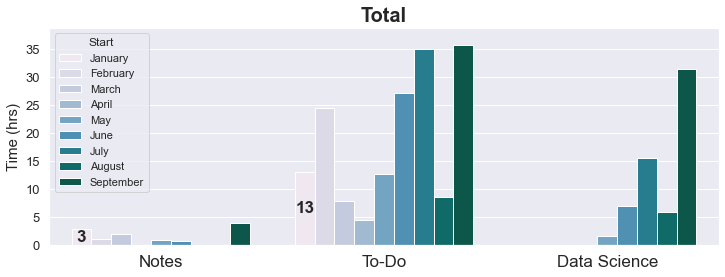

In [68]:
figsize=(12,4)
legendsize=10
title_size=20
bar_label_size=17

sns.set_theme(style="darkgrid")
plt.figure(figsize=figsize)

ax = sns.barplot(x='Project', y='Duration', data=df_month, hue='Start', ci=None, palette='PuBuGn')
plt.xlabel('')
plt.ylabel('Time (hrs)', fontsize=15)
plt.title('Total', fontsize=title_size, fontweight='bold')
ax.bar_label(ax.containers[0], fontsize=bar_label_size, fmt='%.0f', fontweight='bold', label_type='center') # Show values above bars
plt.ylim([0, df_month['Duration'].max() + 3])     # Expand y axis range for visibility
ax.xaxis.set_tick_params(labelsize=17)                         # Enlarge x ticks
ax.yaxis.set_tick_params(labelsize=13)                         # Enlarge x ticks

plt.show()

### 🔴 2. Annual Breakdown

In [14]:
df_year = df.copy()
df_year = df_year.groupby([df_year['Start'].dt.year, 'Project']).sum()
df_year = df_year.reset_index()
df_year['Duration'] /= 3600

df_year

,Start,Project,Task,Duration,Tags
0,2022,Applied Data Science,0.0,52.506111,0.0
1,2022,BML,0.0,22.675833,0.0
2,2022,Data Science,0.0,61.751389,0.0
3,2022,ML2,0.0,31.824167,0.0
4,2022,MSc Project,0.0,116.863056,0.0
5,2022,Machine Learning 1,0.0,5.700556,0.0
6,2022,Notes,0.0,11.694167,0.0
7,2022,Reinforcement Learning,0.0,51.314722,0.0
8,2022,Statistics for Data Science,0.0,12.343333,0.0
9,2022,To-Do,0.0,169.577500,0.0
